In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import lightgbm
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
# optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('OnlineNewsPopularityReduced.csv')
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2014/09/28/jobs-tech-workers/,101,12,332,0.528481,1.0,0.645833,6,3,1,...,0.100000,0.7,-0.145833,-0.166667,-0.125000,0.718182,0.137121,0.218182,0.137121,8600
1,http://mashable.com/2014/09/28/obama-says-u-s-...,101,10,393,0.518817,1.0,0.596899,14,1,1,...,0.250000,0.8,-0.312500,-0.500000,-0.250000,0.500000,0.000000,0.000000,0.000000,23700
2,http://mashable.com/2014/09/28/once-upon-a-tim...,101,13,1643,0.388854,1.0,0.546967,29,4,7,...,0.033333,0.8,-0.227778,-0.800000,-0.050000,0.000000,0.000000,0.500000,0.000000,8400
3,http://mashable.com/2014/09/28/the-simpsons-de...,101,9,272,0.488889,1.0,0.512690,2,2,11,...,0.100000,1.0,-0.416667,-1.000000,-0.166667,0.000000,0.000000,0.500000,0.000000,4800
4,http://mashable.com/2014/09/28/viola-davis-les...,101,12,0,0.000000,0.0,0.000000,0,0,0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.541071,0.067560,0.041071,0.067560,3100


### A bit of preprocessing, this dataset doesn't require a lot.

In [3]:
df = df[df.n_tokens_content != 0]
df.drop(columns=['url', 'kw_min_min'], inplace=True)

In [4]:
df.dtypes

timedelta                          int64
n_tokens_title                     int64
n_tokens_content                   int64
n_unique_tokens                  float64
n_non_stop_words                 float64
n_non_stop_unique_tokens         float64
num_hrefs                          int64
num_self_hrefs                     int64
num_imgs                           int64
num_videos                         int64
average_token_length             float64
num_keywords                       int64
data_channel_is_lifestyle          int64
data_channel_is_entertainment      int64
data_channel_is_bus                int64
data_channel_is_socmed             int64
data_channel_is_tech               int64
data_channel_is_world              int64
kw_max_min                       float64
kw_avg_min                       float64
kw_min_max                         int64
kw_max_max                         int64
kw_avg_max                       float64
kw_min_avg                       float64
kw_max_avg      

### Splitting data into train/validation sets

In [5]:
X = df.drop(columns='shares')
columns = X.columns
y = df.shares
y_log = np.log(y)
scaler = StandardScaler()
X = scaler.fit_transform(X)

### Multi-layer Perceptron

In [6]:
def test_model(model):
    scores = cross_validate(model, X, y_log, cv=4, scoring=['neg_mean_squared_error', 'r2'], return_train_score=True, n_jobs=-1)
    print('Train MSE:', scores['train_neg_mean_squared_error'].mean())
    print('Test MSE:', scores['test_neg_mean_squared_error'].mean())
    print('Train R2:', scores['train_r2'].mean())
    print('Test R2:', scores['test_r2'].mean())

In [7]:
mlp = MLPRegressor((30, 30), solver='lbfgs')
test_model(mlp)

Train MSE: -0.1685729923113578
Test MSE: -1.2917780108115924
Train R2: 0.7849450926927763
Test R2: -0.7118316333410166


Even such small NN is easily overfitting, so we need to carefully pick layers' sizes and regularization coefficient

#### MLP parameters optimization

In [8]:
def objective(trial):
    n_max = 5
    n_layers = trial.suggest_int('n_layers', 1, n_max)
    layers = [trial.suggest_int(f'{i}_layer', 1, 50) for i in range(n_max)]
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'logistic'])
    lr = 10 ** trial.suggest_float('lr', -5, -1)
    alpha = 10 ** trial.suggest_float('r', -10, -1)
    
    return cross_val_score(MLPRegressor(layers[:n_layers], activation, alpha=alpha, learning_rate_init=lr, random_state=1), X, y_log, cv=4, scoring='r2', n_jobs=-1).mean()

In [9]:
# study = optuna.create_study(direction='maximize')

In [10]:
# study.optimize(objective, n_trials=500, n_jobs=-1)

In [11]:
# study.best_params, study.best_value
# {'n_layers': 3,
#   '0_layer': 3,
#   '1_layer': 7,
#   '2_layer': 24,
#   '3_layer': 33,
#   '4_layer': 31,
#   'activation': 'logistic',
#   'lr': -1.3880722233862475,
#   'r': -1.0705194410733687}

In [12]:
bestMLP = MLPRegressor([3, 7, 24], 'params_logistic', learning_rate_init=10 ** -1.3880722233862475, alpha=10 ** -1.0705194410733687, random_state=1)
test_model(bestMLP)

Train MSE: -0.5943095090945947
Test MSE: -0.6926443906410664
Train R2: 0.24102617279696895
Test R2: 0.09450869450185506


This is better r2 score, at least > 0, but, as always with this dataset, overall result is pretty bad. However, linear regression performed even worse.

#### Validation curves

In [13]:
# results = study.trials_dataframe()
# results = results[['params_n_layers', 'params_0_layer', 'params_1_layer', 'params_2_layer', 'params_3_layer', 'params_4_layer', 'params_r', 'params_lr', 'params_activation', 'value']]
# results.to_csv('MLPresults.csv', index=0)

<Axes: xlabel='params_activation'>

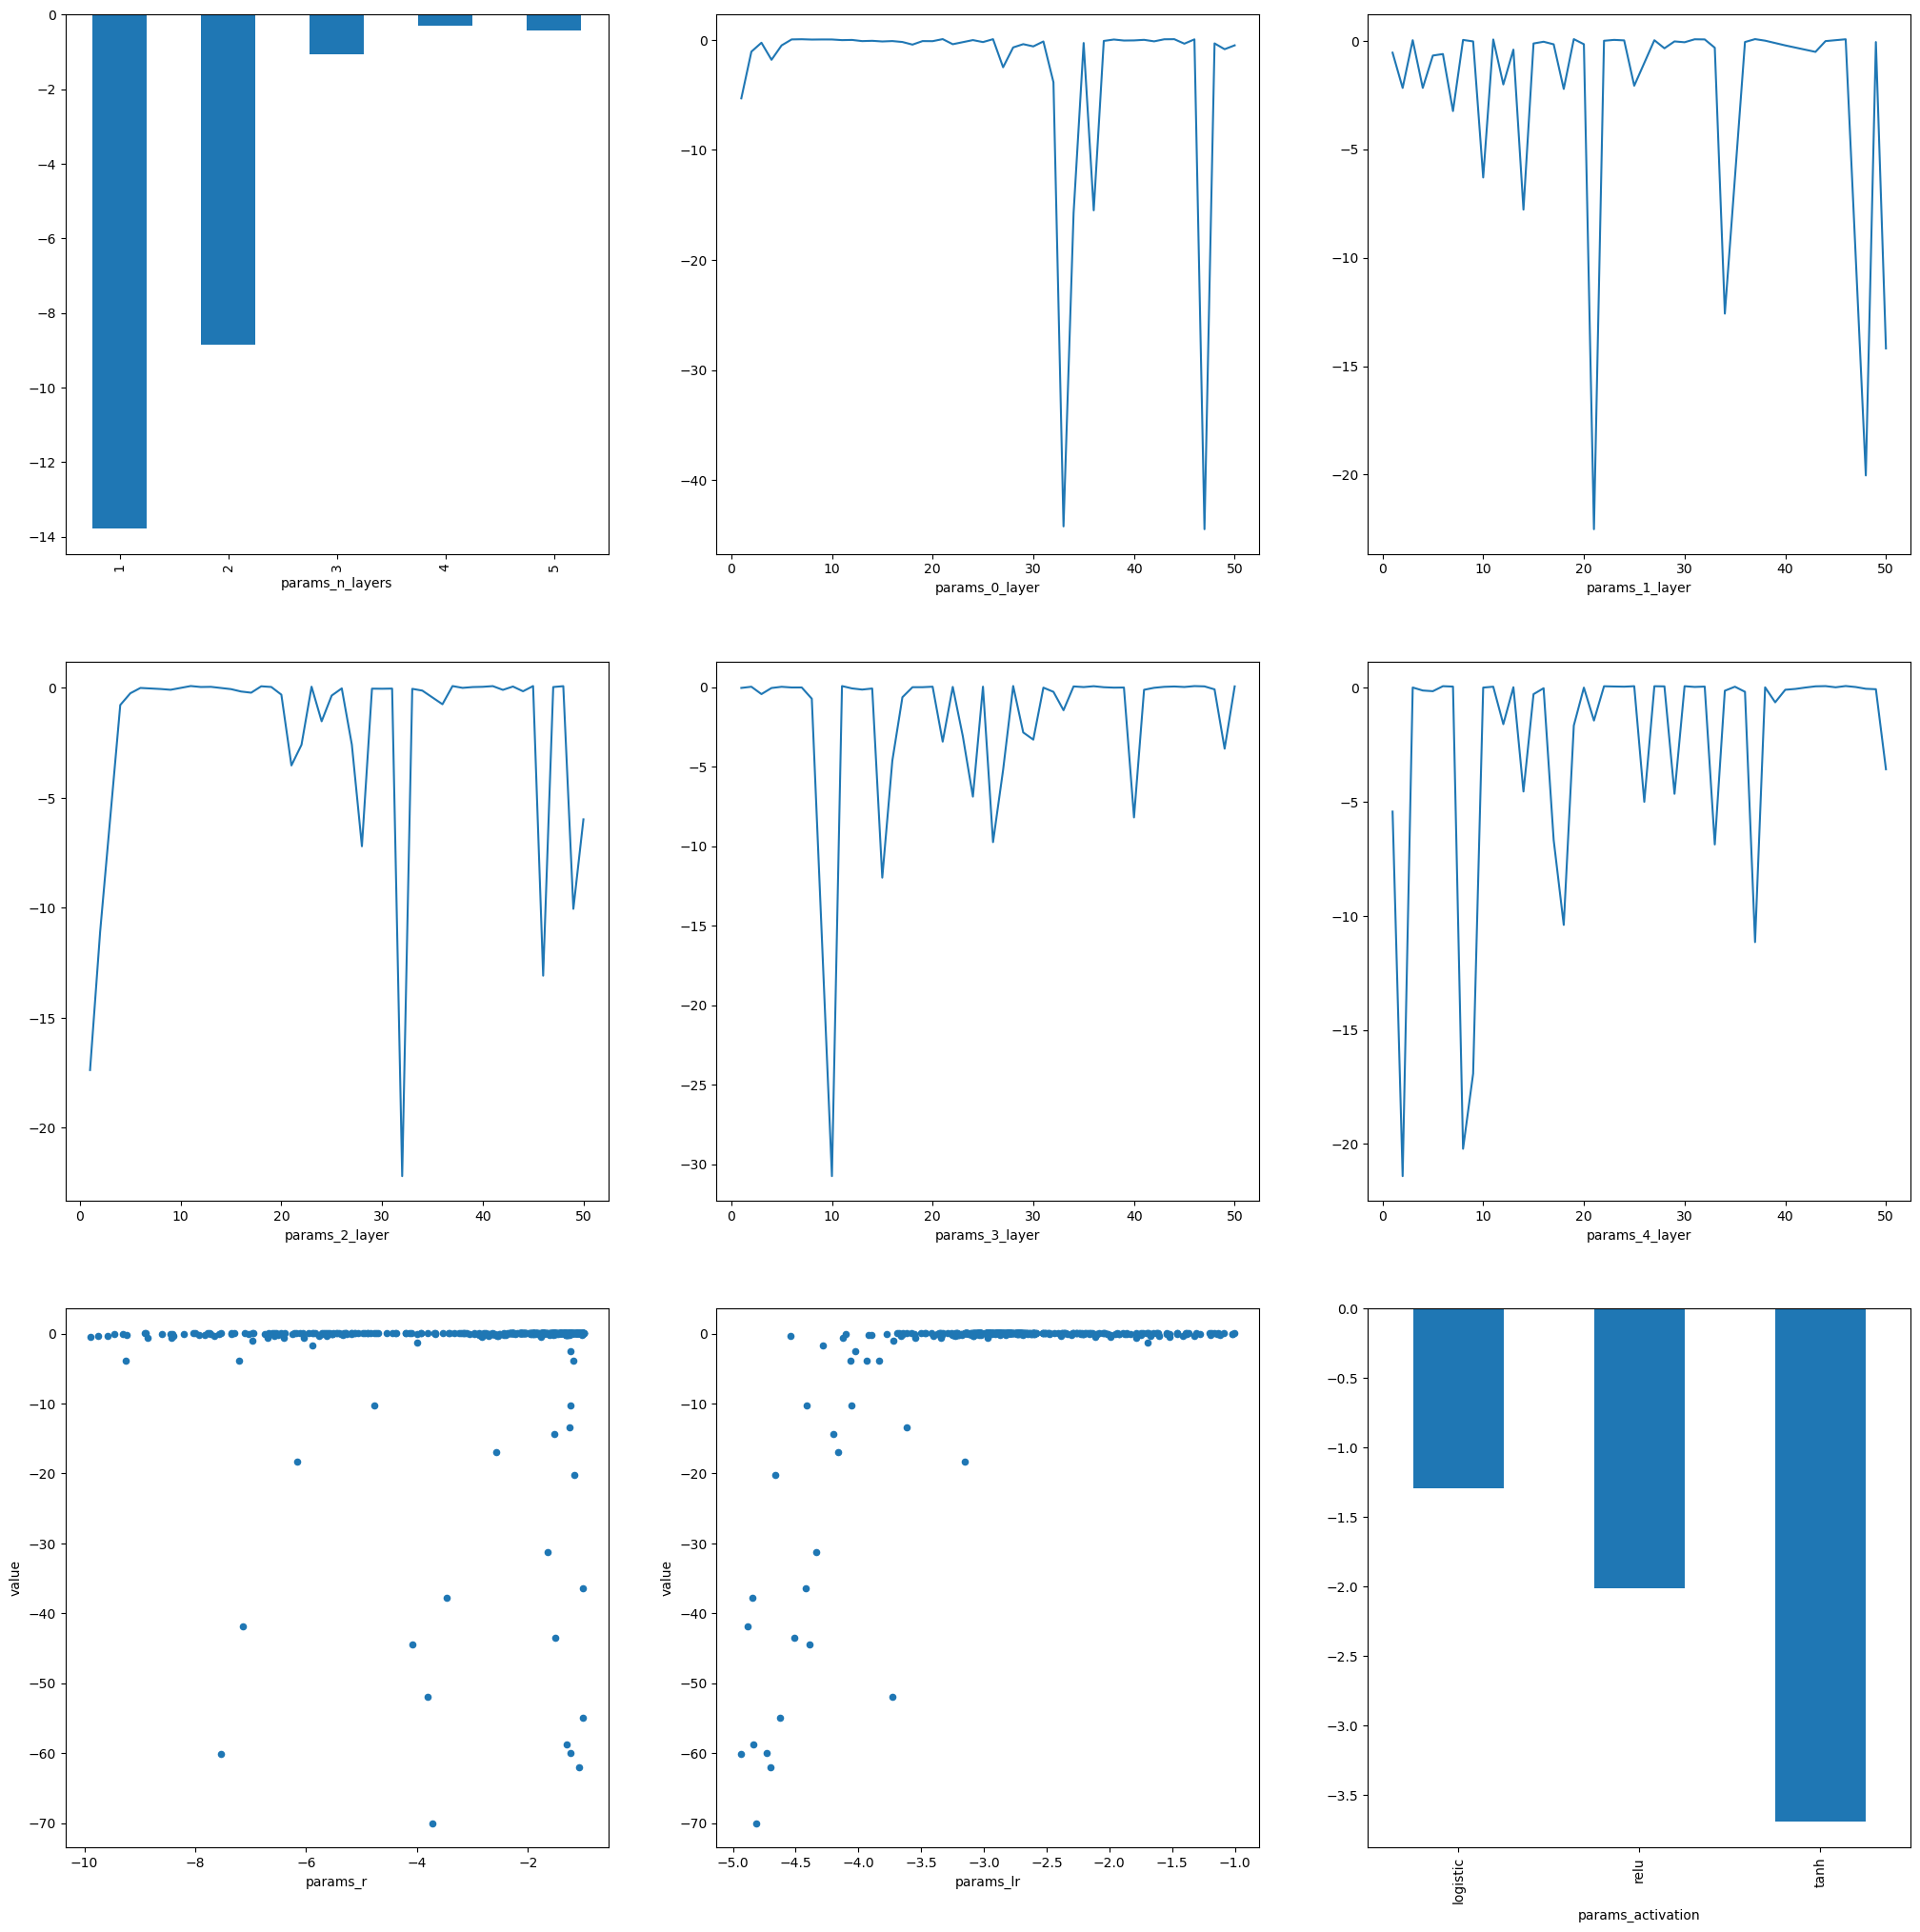

In [14]:
results = pd.read_csv('MLPresults.csv')
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(25, 25))
results.groupby('params_n_layers')['value'].mean().plot(kind='bar', ax=axes[0, 0])
results.groupby('params_0_layer')['value'].mean().plot(ax=axes[0, 1])
results.groupby('params_1_layer')['value'].mean().plot(ax=axes[0, 2])
results.groupby('params_2_layer')['value'].mean().plot(ax=axes[1, 0])
results.groupby('params_3_layer')['value'].mean().plot(ax=axes[1, 1])
results.groupby('params_4_layer')['value'].mean().plot(ax=axes[1, 2])
results.sort_values('params_r').plot('params_r', 'value', ax=axes[2, 0], kind='scatter')
results.sort_values('params_lr').plot('params_lr', 'value', ax=axes[2, 1], kind='scatter')
results.groupby('params_activation')['value'].mean().plot(ax=axes[2, 2], kind='bar')

### 

We can see from the validation curves that in almost every case the result is < 0 or ~ 0, so it is extremely difficult to make any model work well on this dataset.

### Bagging with KNN
#### Basic performance

In [15]:
bagknn = BaggingRegressor(KNeighborsRegressor(), max_samples=0.5)
test_model(bagknn)

Train MSE: -0.5993326982697961
Test MSE: -0.757040671495554
Train R2: 0.2377265570203512
Test R2: 0.0163274080636496


Surprisingly, test r2 score is higher that zero for this model.

In [16]:
def objective(trial):
    knnparams = {
        'n_neighbors': trial.suggest_int('n_neighbors', 1, 30),
        'p': trial.suggest_float('p', 1, 5)
    }
    baggingparams = {
        'max_samples': trial.suggest_float('max_samples', 0, 1),
        'max_features': trial.suggest_float('max_features', 0, 1),
        'n_estimators': trial.suggest_int('n_estimators', 1, 200)
    }
    
    return cross_val_score(BaggingRegressor(KNeighborsRegressor(weights='distance', **knnparams), **baggingparams), X, y_log, cv=4, scoring='r2', n_jobs=-1).mean()

In [17]:
# study = optuna.create_study(direction='maximize')

In [18]:
# study.optimize(objective, n_trials=200, n_jobs=-1)

In [19]:
{'n_neighbors': 13, 'p': 1.0020642775965056, 'max_samples': 0.9854246973394611, 'max_features': 0.2584574070122636, 'n_estimators': 119}
bestBagging = BaggingRegressor(KNeighborsRegressor(n_neighbors=13, p=1.002064), max_samples=0.985424, max_features=0.258457, n_estimators=119)
# test_model(bestBagging)

```
Train MSE: -0.5828321756688972
Test MSE: -0.7143835095602113
Train R2: 0.2582553935616767
Test R2: 0.07448777243320309
```
Even though knn bagging with default parameters performed relatively good, with best parameters it performs worse than MLP

### DT Boosting
#### Default parameters

In [20]:
gb = lightgbm.LGBMRegressor(max_depth=5)
test_model(gb)

Train MSE: -0.28449003976303855
Test MSE: -0.674455623791872
Train R2: 0.6371880047315656
Test R2: 0.12074902924214415


This result is already better that everything before

In [35]:
def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 128),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'max_depth': trial.suggest_int('max_depth', 1, 7),
        'n_estimators':trial.suggest_int('n_estimators', 1, 500),
        'learning_rate': 10 ** trial.suggest_float('learning_rate', -4, -1),
        'lambda_l1': 10 ** trial.suggest_float('lambda_l1', -7, -1),
        'lambda_l2': 10 ** trial.suggest_float('lambda_l2', -7, -1),
        'subsample': trial.suggest_float('subsample', 0, 1),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 10)
    }
    return cross_val_score(lightgbm.LGBMRegressor(**params), X, y_log, cv=4, scoring='r2', n_jobs=-1).mean()

In [33]:
# study = optuna.create_study(direction='maximize')

[I 2023-11-30 18:58:00,171] A new study created in memory with name: no-name-76226a45-4389-4806-9d11-3ed45a61a4e0


In [37]:
# study.optimize(objective, n_trials=100, n_jobs=-1)

[I 2023-11-30 19:00:06,296] Trial 392 finished with value: -0.04999556280309814 and parameters: {'num_leaves': 104, 'min_data_in_leaf': 5, 'max_depth': 3, 'n_estimators': 77, 'learning_rate': -3.518749236911175, 'lambda_l1': -6.092368718512, 'lambda_l2': -3.03038402241396, 'subsample': 0.4948924447851087, 'subsample_freq': 1}. Best is trial 222 with value: 0.15002900590729312.
[I 2023-11-30 19:00:06,653] Trial 406 finished with value: 0.04970712033028529 and parameters: {'num_leaves': 104, 'min_data_in_leaf': 5, 'max_depth': 3, 'n_estimators': 352, 'learning_rate': -2.6888999099642232, 'lambda_l1': -6.056290848829771, 'lambda_l2': -3.11170341398926, 'subsample': 0.49685761960120217, 'subsample_freq': 1}. Best is trial 222 with value: 0.15002900590729312.
[I 2023-11-30 19:00:06,685] Trial 394 finished with value: 0.01131237810935884 and parameters: {'num_leaves': 102, 'min_data_in_leaf': 5, 'max_depth': 3, 'n_estimators': 419, 'learning_rate': -3.0628654092422503, 'lambda_l1': -6.065951

In [38]:
# study.best_params

{'num_leaves': 110,
 'min_data_in_leaf': 5,
 'max_depth': 3,
 'n_estimators': 404,
 'learning_rate': -1.610700557221474,
 'lambda_l1': -6.144713337879425,
 'lambda_l2': -3.3876574038839222,
 'subsample': 0.5080944121394215,
 'subsample_freq': 1}

In [40]:
best_params = {
    'num_leaves': 110,
    'min_data_in_leaf': 5,
    'max_depth': 3,
    'n_estimators': 404,
    'learning_rate': 10 ** -1.610700557221474,
    'lambda_l1': 10 ** -6.144713337879425,
    'lambda_l2': 10 ** -3.3876574038839222,
    'subsample': 0.5080944121394215,
    'subsample_freq': 1
}
bestGB = lightgbm.LGBMRegressor(**best_params)
test_model(bestGB)

Train MSE: -0.42535267712162045
Test MSE: -0.6506567389327825
Train R2: 0.4569824140245794
Test R2: 0.15002900590729312


Still quite overfitted, still pretty bad, but it's much better than every model before.

In [42]:
# results = study.trials_dataframe()
# results = results[['params_num_leaves', 'params_min_data_in_leaf', 'params_max_depth', 'params_n_estimators', 'params_learning_rate', 'params_lambda_l1', 'params_lambda_l2', 'params_subsample', 'params_subsample_freq', 'value']]
# results.to_csv('LGBMresults.csv', index=0)

<Axes: xlabel='params_subsample_freq'>

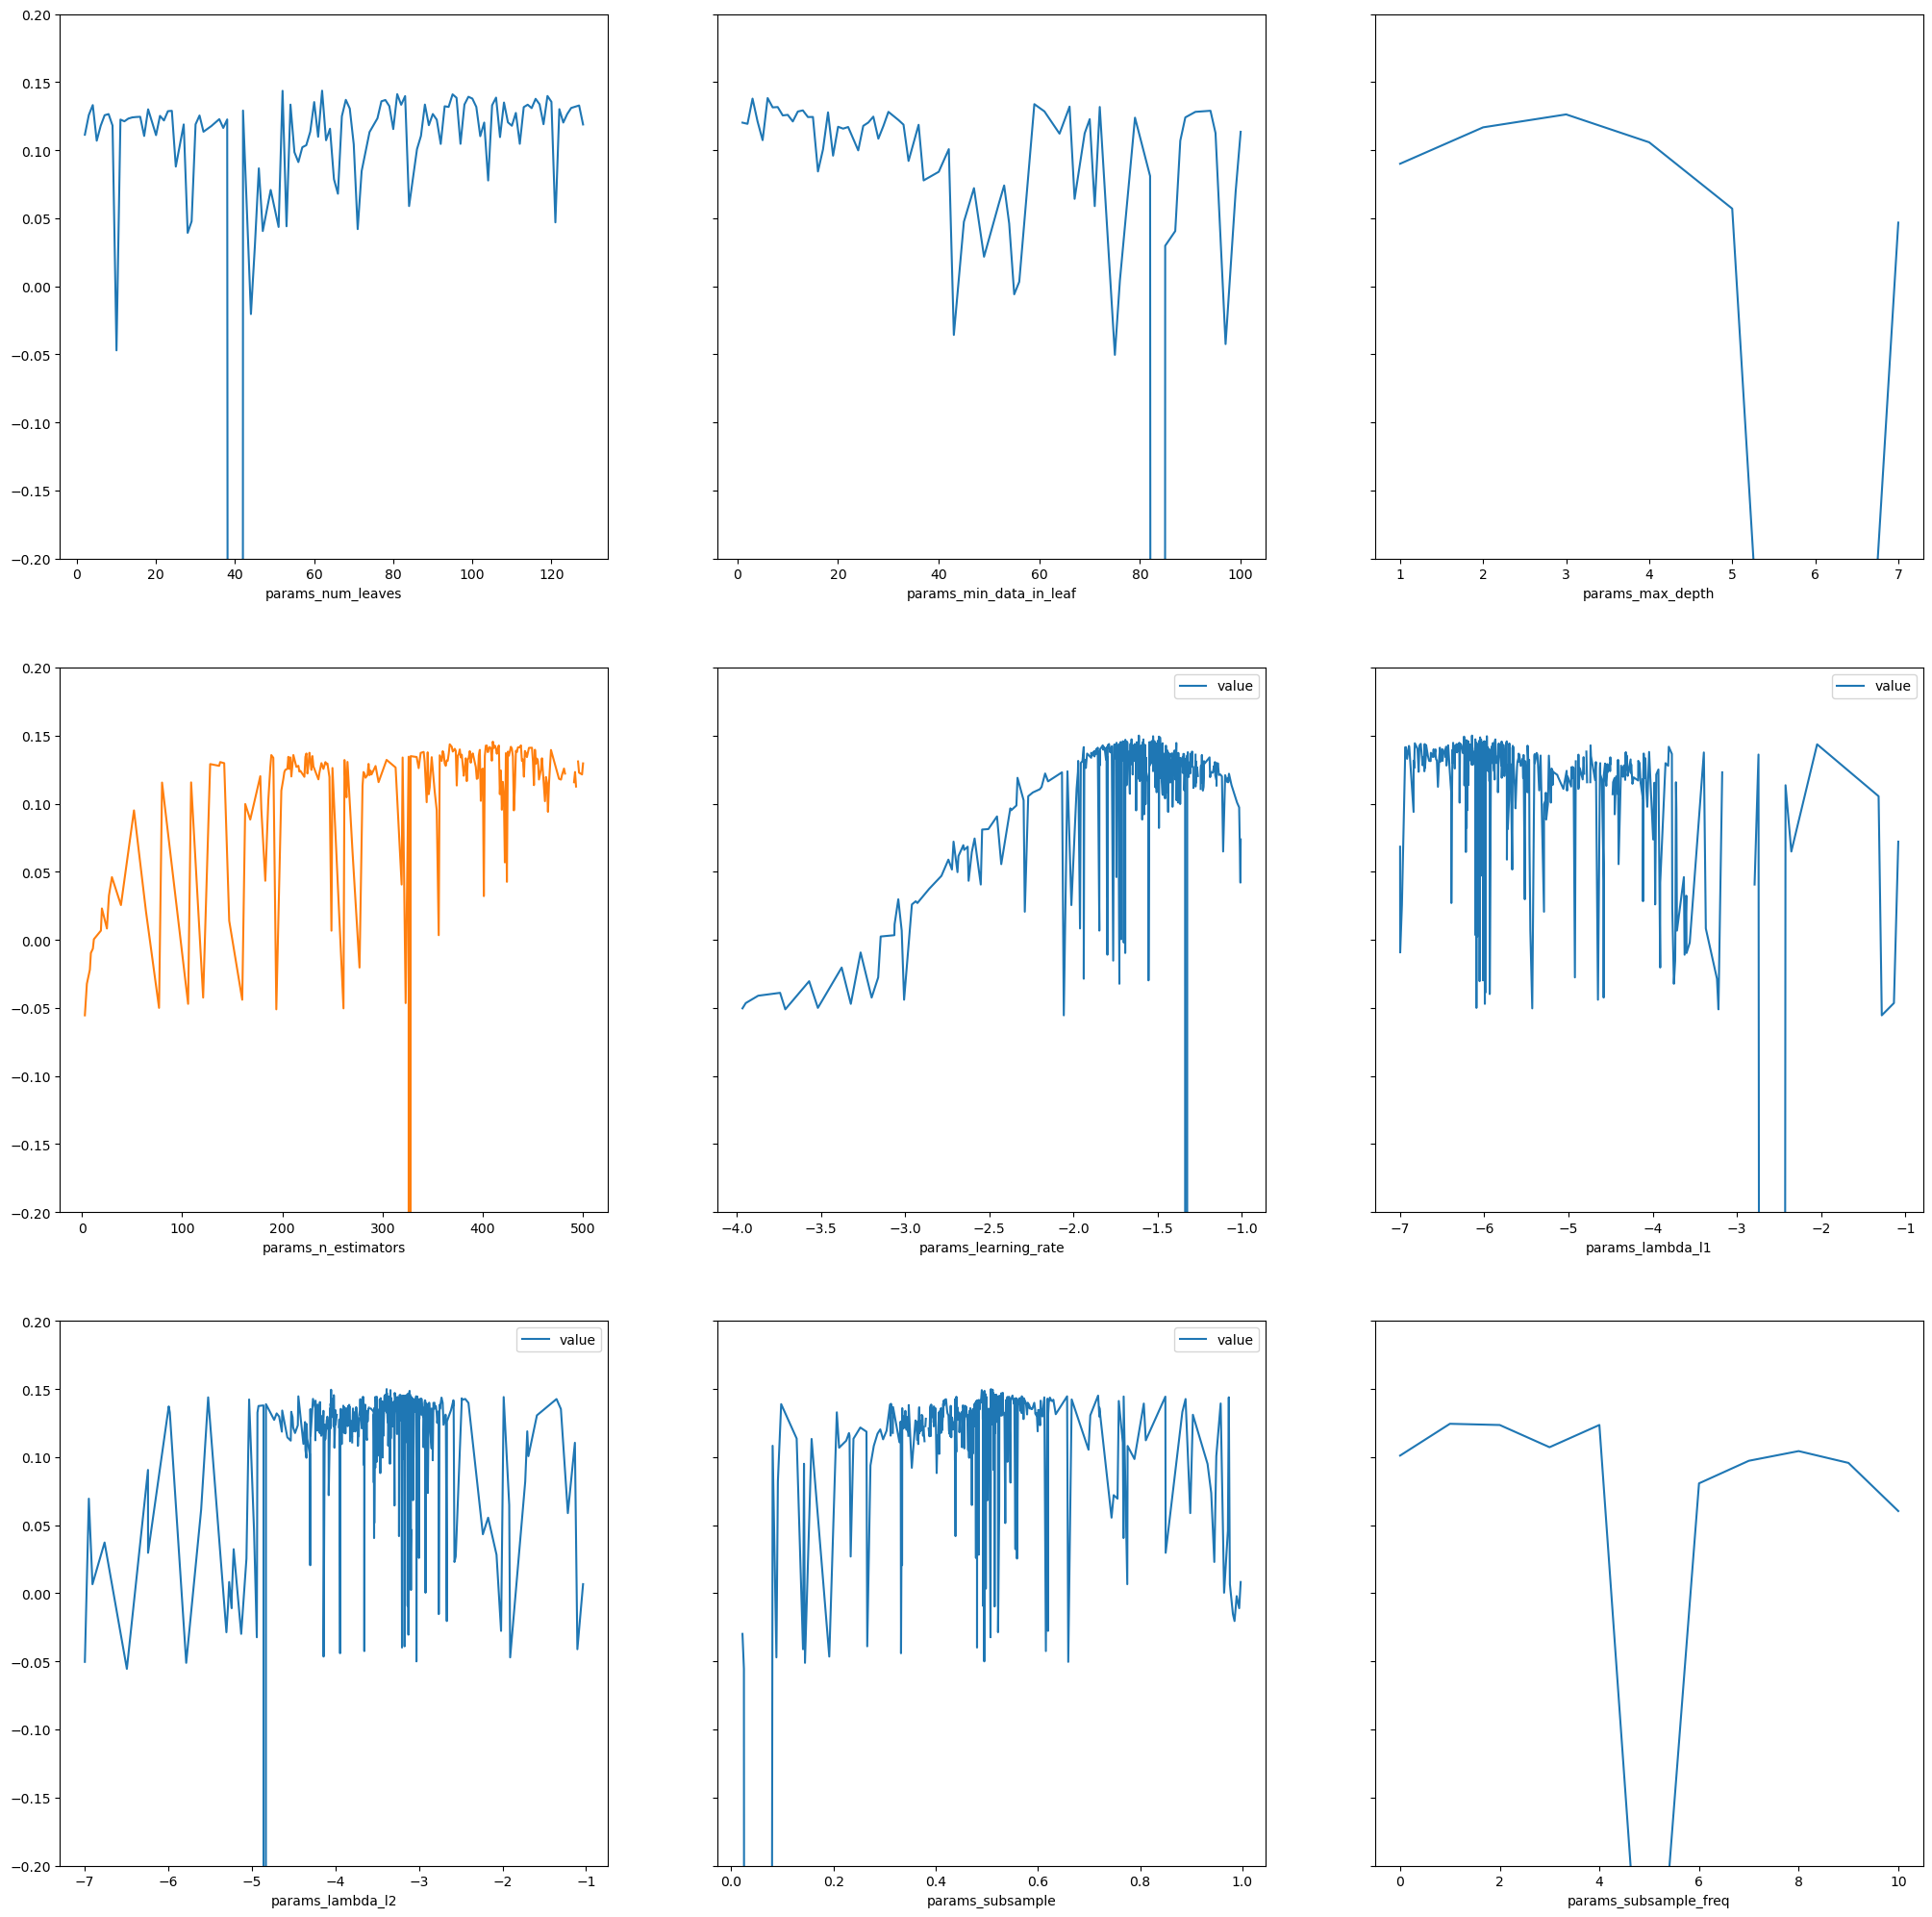

In [59]:
results = pd.read_csv('LGBMresults.csv')
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(25, 25), sharey=True)
plt.ylim(-0.2, 0.2)
results.groupby('params_num_leaves')['value'].mean().plot(ax=axes[0, 0])
results.groupby('params_min_data_in_leaf')['value'].mean().plot(ax=axes[0, 1])
results.groupby('params_max_depth')['value'].mean().plot(ax=axes[0, 2])
results.groupby('params_n_estimators')['value'].mean().plot(ax=axes[1, 0], c='tab:orange')
results.sort_values('params_learning_rate').plot('params_learning_rate', 'value', ax=axes[1, 1])
results.sort_values('params_lambda_l1').plot('params_lambda_l1', 'value', ax=axes[1, 2])
results.sort_values('params_lambda_l2').plot('params_lambda_l2', 'value', ax=axes[2, 0])
results.sort_values('params_subsample').plot('params_subsample', 'value', ax=axes[2, 1])
results.groupby('params_subsample_freq')['value'].mean().plot(ax=axes[2, 2])

There are nothing interesting on validation curves, besides that for some reason each curve has one big dip.

### Conclusion
Top 5 models by r2 test score: 
- LGBM, score - 0.1500
- MLP, score - 0.0945
- kNN bagging, score - 0.0744
- Linear regression + L1, L2 regularization, score - 0.0318
- Linear regression + L2 regularization, score - 0.0149

So quality of model is best for LGBM, but this is not it's only power. LGBM is much, much quicker than MLP or kNN bagging, which is a massive advantage. I was able to train 5-10 LGBM models with 400+ trees in just a second, whereas 1 kNN bagging required ~1 min to train.